# Compulsory Assignment 2: Convolutional neural networks

Please fill out the the group name, number, members and optionally the name below.

**Group number**: 31 \
**Group member 1**: Asim Rasheed\
**Group member 2**: Jony Karmakar\
**Group member 3**: Haris Hameed Mian\
**Group name (optional)**: Group 31 

Make sure that the group name given in the assignment is the same that you use on the Kaggle Leaderboard.

# Assignment Submission
To complete this assignment answer the relevant questions in this notebook and write the code required to implement the relevant models. The assignment is submitted by handing in this notebook as an .ipynb file and as a .pdf file. In addition, you are required to submit at least one test prediction to the Kaggle leaderboard that is better than the *BEAT ME* score. And, for fun see if you can beat the SandvikNet submission score.

NOTE: Remember to go through the rules given in the lecture "Introduction to compulsory assignments", as there are many do's and dont's with regard to how you should present the work you are going to submit. 

# Introduction 
This assignment will start with classifying handwritten digits from the MNIST dataset, used in the voluntary assignment and the first compulsory assignment. The second part of this task will revolve around classifying the open-source CIFAR-10 dataset.

## CIFAR-10

The CIFAR-10 dataset is a labeled subsets of the [80 million tiny images dataset](http://groups.csail.mit.edu/vision/TinyImages/). The images were collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton. It consists of 60 000 32x32 RGB images with partitioned into 10 classes depicted below.

<center><img src="cifar_10_illustration.png" width="500" height="400"></center>

Each annotation class contains 6 000 images. You will be provided `X_train` with 50 000 annotated samples, and `X_test` with 10 000 unlabelled samples.

## Assignment structure

1. Part 1: Implementing LeNet for classifying MNIST.
2. Part 2: Designing your own CNN for classifying CIFAR-10

## Submissions to the Kaggle leaderboard
Use the following code to create the `submission.csv` file that you can submit to the Kaggle leaderboard. 

```python
prediction = model.predict(X_test)
flat_prediction = np.argmax(prediction, axis=1) # Flatten softmax predictions
submissionDF = pd.DataFrame()
submissionDF['ID'] = range(len(flat_prediction)) # The submission csv file must have an row index column called 'ID'
submissionDF['Prediction'] = flat_le_net_prediction
submissionDF.to_csv('submission.csv', index=False) # Remember to store the dataframe to csv without the nameless index column.
```

## Library imports

In [4]:
# Feel free to add or remove libraries as you want
import time
from tqdm import tqdm # Cool progress bar

import numpy as np
import pandas as pd
import h5py

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow.keras as ks
from tensorflow.keras.utils import to_categorical

SEED = 458
RNG = np.random.default_rng(SEED) # Random number generator

from utilities import *

# Part 1: CNN for classifying the MNIST dataset

## Loading MNIST

In [97]:
datasets = load_mnist(verbose=0)
X_train, y_train = datasets['X_train'], datasets['y_train']
X_val,   y_val   = datasets['X_val'],   datasets['y_val']
X_test,  y_test  = datasets['X_test'],  datasets['y_test']

X_train = np.concatenate([X_train, X_val], axis=0)
y_train = np.concatenate([y_train, y_val], axis=0).astype('int32')

del datasets, X_val, y_val # Good to reduce uneccesary RAM usage

## Preprocessing

In [98]:
# Reshape data to account for color channel
X_train = np.expand_dims(X_train, -1)
X_test  = np.expand_dims(X_test, -1)

# Normalizing input between [0,1]
X_train = X_train.astype("float32")/np.max(X_train)
X_test  = X_test.astype("float32")/np.max(X_test)

# Converting targets from numbers to categorical format
y_train = ks.utils.to_categorical(y_train, len(np.unique(y_train)))
y_test  = ks.utils.to_categorical(y_test, len(np.unique(y_test)))

## Task 1.1: Build a network with the LeNet CNN architecture

### Task 1.1.1 Building network

Implement the famous LeNet architecture according to the following specifications: 

--------------------------
The LeNet architecture takes a 28x28xC image as input, where C is the number of color channels. Since MNIST images are grayscale, C is 1 in this case.

**Layer 1 - Convolution (5x5):** The output shape should be 28x28x6. **Activation:** ReLU. 

**MaxPooling:** The output shape should be 14x14x6.

**Layer 2 - Convolution (5x5):** The output shape should be 10x10x16. **Activation:** ReLU. 

**MaxPooling:** The output shape should be 5x5x16.

**Flatten:** Flatten the output shape of the final pooling layer such that it's 1D instead of 3D.  You may need to use tf.reshape.

**Layer 3 - Fully Connected:** This should have 120 outputs. **Activation:** ReLU.

**Layer 4 - Fully Connected:** This should have 84 outputs. **Activation:** ReLU.

**Layer 5 - Fully Connected:** This should have 10 outputs. **Activation:** softmax.

--------------------------

Compile the network with the
* `MSE` loss function
* the `adam` optimizer 
* with the `accuracy` metric and (your own implementation of the) F1-score metric.

In [5]:
# Define LeNet Architecture
def LeNet(input_shape=(28, 28, 1), num_classes=10):
    model = ks.models.Sequential()
    
    # Layer 1: Convolution
    model.add(ks.layers.Conv2D(6, (5, 5), activation='relu', input_shape=input_shape, padding='same'))
    # MaxPooling
    model.add(ks.layers.MaxPooling2D((2, 2)))
    
    # Layer 2: Convolution
    model.add(ks.layers.Conv2D(16, (5, 5), activation='relu'))
    # MaxPooling
    model.add(ks.layers.MaxPooling2D((2, 2)))
    
    # Flatten
    model.add(ks.layers.Flatten())
    
    # Layer 3: Fully Connected
    model.add(ks.layers.Dense(120, activation='relu'))
    
    # Layer 4: Fully Connected
    model.add(ks.layers.Dense(84, activation='relu'))
    
    # Layer 5: Fully Connected
    model.add(ks.layers.Dense(num_classes, activation='softmax'))
    
    return model

# Define F1-score metric
# def f1_score(y_true, y_pred):
#     true_positives = ks.backend.sum(ks.backend.round(ks.backend.clip(y_true * y_pred, 0, 1)))
#     possible_positives = ks.backend.sum(ks.backend.round(ks.backend.clip(y_true, 0, 1)))
#     predicted_positives = ks.backend.sum(ks.backend.round(ks.backend.clip(y_pred, 0, 1)))
    
#     precision = true_positives / (predicted_positives + ks.backend.epsilon())
#     recall = true_positives / (possible_positives + ks.backend.epsilon())
    
#     f1_val = 2 * (precision * recall) / (precision + recall + ks.backend.epsilon())
#     return f1_val

# Initialize and compile the model
model = LeNet()
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])


# Model Summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 6)         156       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 6)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 16)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 400)               0         
                                                                 
 dense (Dense)               (None, 120)               4

### Task 1.1.2 Train network

Train the network with a 
* batch size of 128 samples
* for 40 epochs
* 1/6 validation split

In [6]:
# Train the model
history = model.fit(
    x=X_train, 
    y=y_train, 
    batch_size=128, 
    epochs=40, 
    validation_split=1/6,
    shuffle=True
)



Epoch 1/40
391/391 [==============================] - 19s 44ms/step - loss: 0.0167 - accuracy: 0.8833 - val_loss: 0.0063 - val_accuracy: 0.9585
Epoch 2/40
391/391 [==============================] - 18s 46ms/step - loss: 0.0049 - accuracy: 0.9682 - val_loss: 0.0042 - val_accuracy: 0.9716
Epoch 3/40
391/391 [==============================] - 18s 47ms/step - loss: 0.0036 - accuracy: 0.9766 - val_loss: 0.0029 - val_accuracy: 0.9812
Epoch 4/40
391/391 [==============================] - 18s 46ms/step - loss: 0.0029 - accuracy: 0.9816 - val_loss: 0.0028 - val_accuracy: 0.9823
Epoch 5/40
391/391 [==============================] - 23s 58ms/step - loss: 0.0024 - accuracy: 0.9848 - val_loss: 0.0028 - val_accuracy: 0.9825
Epoch 6/40
391/391 [==============================] - 20s 50ms/step - loss: 0.0022 - accuracy: 0.9862 - val_loss: 0.0031 - val_accuracy: 0.9807
Epoch 7/40
391/391 [==============================] - 17s 45ms/step - loss: 0.0019 - accuracy: 0.9883 - val_loss: 0.0027 - val_accuracy:

### Task 1.1.3 Plot training history and evaluate on test dataset

In [ ]:
prediction = model.predict(X_test)
flat_prediction = np.argmax(prediction, axis=1) # Flatten softmax predictions
submissionDF = pd.DataFrame()
submissionDF['ID'] = range(len(flat_prediction)) # The submission csv file must have an row index column called 'ID'
submissionDF['Prediction'] = flat_prediction
submissionDF.to_csv('submission.csv', index=False) 

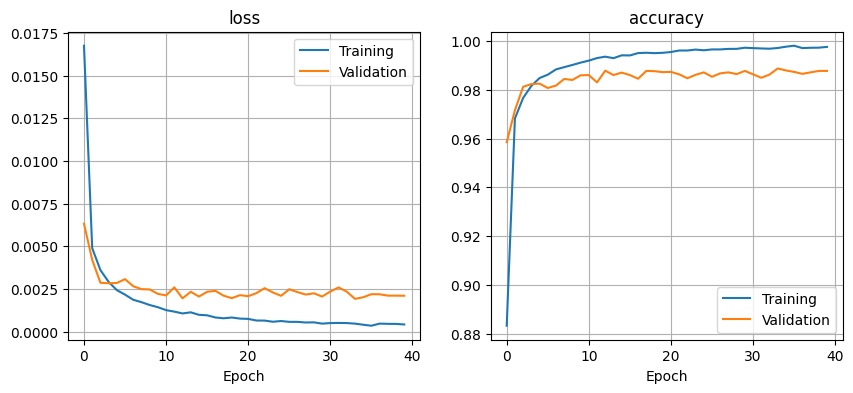

In [7]:
plot_training_history(history)

### Task 1.1.4 Evaluate on the test dataset

In [8]:
#Evaluate the model (optional)
test_loss, test_accuracy = model.evaluate(X_test, y_test)

313/313 [==============================] - 2s 7ms/step - loss: 0.0019 - accuracy: 0.9888


## Task 1.2: MNIST discussion

**Task 1.2.1: Does overfitting occur? If so, after how many epochs?**

 $\color{red}{\text{Response}}$ \
Yes, overfitting of the data has been observed and it occured after 6 Epochs. The training and validation loss has been plotted above. The training loss is significantly lower than the validation (or test) loss, indicating overfitting. Overfit models have "memorized" the training data, leading to a low training loss, but it fail to generalize to new data, resulting in a higher validation loss. As can be seen from the figure, a widening gap between the training and validation accuracy is also an indication of the overfitting.

**Task 1.2.2: How do the results of the LeNet implementation compare to the results of your models from CA1?**

**Task 1.2.2** $\color{red}{\text{Response}}$

**CA1 (Tensor flow-Keras) Model**:
- Training was done for 5 epochs.
- Test Accuracy: 97.36%
- Test Loss: 0.0852
- Weighted F1 Score: 97.36%

**The LeNet CNN Model**:
- Training was done for 40 epochs.
- Validation F1-scores range from 95.72% to 98.79%.

$\color{blue}{\text{The results have been summarised in Table shown below}}$

The LeNet CNN model trains significantly faster, with each epoch taking only a few seconds, compared to the Keras model, which takes several seconds per epoch.

The Keras model achieves a test accuracy of 97.36%. The weighted F1 score for the Keras model is also 97.36%, indicating good overall performance.

The LeNet CNN model achieves validation F1-scores ranging from 95.72% to 98.79% during its training. This suggests that the LeNet model is performing very well on the validation set, with F1-scores consistently above 95%.

In comparison, the LeNet CNN model appears to outperform the Keras model in terms of validation F1-score, but it also requires more training epochs. The Keras model achieves a good test accuracy and F1-score after just 5 epochs, but the LeNet model continues to improve its performance with more training. 

In [1]:
from tabulate import tabulate

data = [
    ["CA1 (TensorFlow-Keras) Model", "5 epochs", "97.36%", "0.0852", "97.36%"],
    ["The LeNet CNN Model", "40 epochs", "95.72% - 98.79%", "0.0021", "98.62%"],
]

headers = ["Model", "Training Duration", "Test Accuracy", "Test Loss", "Weighted F1 Score"]

table = tabulate(data, headers, tablefmt="pretty")
print(table)

+------------------------------+-------------------+-----------------+-----------+-------------------+
|            Model             | Training Duration |  Test Accuracy  | Test Loss | Weighted F1 Score |
+------------------------------+-------------------+-----------------+-----------+-------------------+
| CA1 (TensorFlow-Keras) Model |     5 epochs      |     97.36%      |  0.0852   |      97.36%       |
|     The LeNet CNN Model      |     40 epochs     | 95.72% - 98.79% |  0.0021   |      98.62%       |
+------------------------------+-------------------+-----------------+-----------+-------------------+



**Task 1.2.3: Given the accuracy that your implementation of the LeNet attained on the test-dataset, what would the expected error-rate be if your model was appplied to read 10-digit handwritten number?**

$\color{red}{\text{Response}}$

The test accuracy of your LeNet model is approximately 98.80%. Therefore, the expected error rate would be:

$\color{green}{\text{Expected Error Rate}}$ = 1 - 0.9880 = 0.0120

So, the expected error rate is approximately 1.20%, assuming the data distribution is similar to the test dataset.

# Task 2: CNN for classifying the CIFAR-10 dataset

In this task you shall implement a CNN model, and train it to classify the images in the CIFAR-10 dataset.

## Importing CIFAR-10

Make sure file `student_dataset_CIFAR10.h5` is in the same directory as this notebook. Or you can edit the path from where it is read from. 

In [20]:
dataset_path = './student_dataset_CIFAR10.h5'

with h5py.File(dataset_path,'r') as f:
    print('Datasets in file:', list(f.keys()))
    X_train = np.asarray(f['X_train'])
    y_train = np.asarray(f['y_train'])
    X_test  = np.asarray(f['X_test'])
    print('Nr. train images: %i'%(X_train.shape[0]))
    print('Nr. test images: %i'%(X_test.shape[0]))

label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Datasets in file: ['X_test', 'X_train', 'y_train']
Nr. train images: 50000
Nr. test images: 10000


In [21]:
y_train = ks.utils.to_categorical(y_train, num_classes=10)
print(X_train.shape, y_train.shape, X_test.shape)

(50000, 32, 32, 3) (50000, 10) (10000, 32, 32, 3)


## Task 2.1: Preprocess the data

Preprocess the data as you see fit

In [22]:
# Reduce pixel values
x_train, x_test = X_train / 255.0, X_test / 255.0

## Task 2.2: Visualize the dataset

Plot a few samples images and masks. Feel free to visualize any other aspects of the dataset that you feel are relevant. 

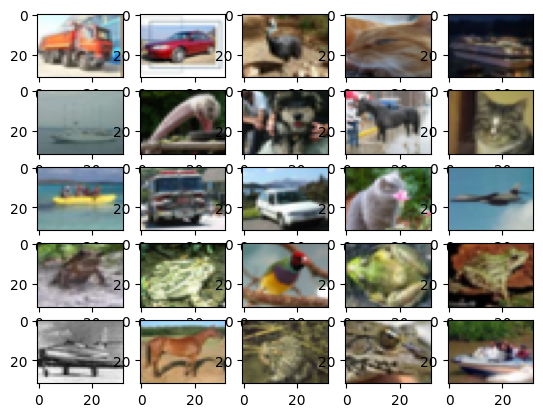

In [13]:
# visualize data by plotting images
fig, ax = plt.subplots(5, 5)
k = 0
 
for i in range(5):
    for j in range(5):
        ax[i][j].imshow(x_train[k], aspect='auto')
        k += 1
 
plt.show()

## Task 2.3: Build a CNN for classifying the CIFAR-10 dataset

Feel free to take inspiration from one of the famous architectures such as LeNet. If you do, please describe where you take inspiration from and give short descriptions on your choice of architecture. 

In [23]:

# Initialize the model
model = ks.Sequential([
    # First Conv Block
    ks.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=x_train[0].shape),
    ks.layers.BatchNormalization(),
    ks.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    # ks.layers.BatchNormalization(),
    ks.layers.MaxPooling2D((2, 2)),
    
    # Second Conv Block
    ks.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    ks.layers.BatchNormalization(),
    ks.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    ks.layers.BatchNormalization(),
    ks.layers.MaxPooling2D((2, 2)),
    
    # Third Conv Block
    ks.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    ks.layers.BatchNormalization(),
    ks.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    ks.layers.BatchNormalization(),
    ks.layers.MaxPooling2D((2, 2)),
    
    # Flatten the output of the conv layers
    ks.layers.Flatten(),
    ks.layers.Dropout(0.2),
    
    # Fully connected layer
    ks.layers.Dense(1024, activation='relu'),
    ks.layers.Dropout(0.2),
    
    # Output layer
    ks.layers.Dense(10, activation='softmax')
])

# Compile
model.compile(optimizer='adam',
              loss= ks.losses.CategoricalCrossentropy(), 
              metrics=['accuracy'])

# Model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_5 (Bat  (None, 32, 32, 32)        128       
 chNormalization)                                                
                                                                 
 conv2d_10 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 batch_normalization_6 (Bat  (None, 16, 16, 64)       

In [30]:


# Initialize the model
model = ks.Sequential([
    # First Conv Block
    ks.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=x_train[0].shape),
    ks.layers.BatchNormalization(),
    ks.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    ks.layers.BatchNormalization(),
    ks.layers.MaxPooling2D((2, 2)),
    
    # Second Conv Block
    ks.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    ks.layers.BatchNormalization(),
    ks.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    ks.layers.BatchNormalization(),
    ks.layers.MaxPooling2D((2, 2)),
    
    # Third Conv Block
    ks.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    ks.layers.BatchNormalization(),
    ks.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    ks.layers.BatchNormalization(),
    ks.layers.MaxPooling2D((2, 2)),
    
    # Flatten the output of the conv layers
    ks.layers.Flatten(),
    ks.layers.Dropout(0.2),
    
    # Fully connected layer
    ks.layers.Dense(1024, activation='relu'),
    ks.layers.Dropout(0.5),
    
    # Output layer
    ks.layers.Dense(10, activation='softmax')
])

# Compile
model.compile(optimizer='adam',
              loss= ks.losses.CategoricalCrossentropy(), 
              metrics=['accuracy'])

# Model summary
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_10 (Ba  (None, 32, 32, 32)        128       
 tchNormalization)                                               
                                                                 
 conv2d_22 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_11 (Ba  (None, 32, 32, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 16, 16, 32)        0         
 ng2D)                                                           
                                                      

## Task 2.4: Evaluate your best model on the test dataset and submit your prediction to the Kaggle leaderboard

In [31]:
history = model.fit(
  x_train, y_train, validation_split=0.2, epochs=10)


Epoch 1/10
1250/1250 [==============================] - 269s 211ms/step - loss: 1.5489 - accuracy: 0.4694 - val_loss: 1.4044 - val_accuracy: 0.5047
Epoch 2/10
1250/1250 [==============================] - 399s 319ms/step - loss: 1.0535 - accuracy: 0.6350 - val_loss: 1.0086 - val_accuracy: 0.6600
Epoch 3/10
1250/1250 [==============================] - 284s 227ms/step - loss: 0.8821 - accuracy: 0.6980 - val_loss: 0.8724 - val_accuracy: 0.7058
Epoch 4/10
1250/1250 [==============================] - 247s 197ms/step - loss: 0.7705 - accuracy: 0.7401 - val_loss: 0.7670 - val_accuracy: 0.7388
Epoch 5/10
1250/1250 [==============================] - 242s 194ms/step - loss: 0.6799 - accuracy: 0.7685 - val_loss: 0.7180 - val_accuracy: 0.7584
Epoch 6/10
1250/1250 [==============================] - 249s 199ms/step - loss: 0.5894 - accuracy: 0.7983 - val_loss: 0.6622 - val_accuracy: 0.7758
Epoch 7/10
1250/1250 [==============================] - 249s 199ms/step - loss: 0.5286 - accuracy: 0.8176 - val_

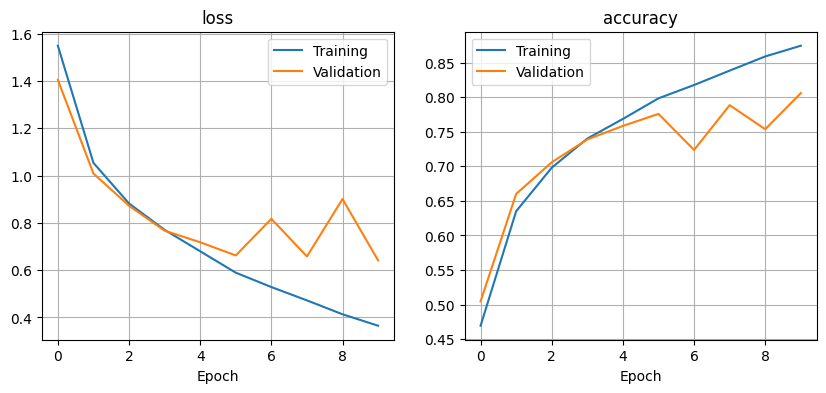

In [32]:
plot_training_history(history)

In [34]:
prediction = model.predict(x_test)
flat_prediction = np.argmax(prediction, axis=1) # Flatten softmax predictions
submissionDF = pd.DataFrame()
submissionDF['ID'] = range(len(flat_prediction)) # The submission csv file must have an row index column called 'ID'
submissionDF['Prediction'] = flat_prediction
submissionDF.to_csv('submissionnew2.csv', index=False) # Remember to store the dataframe to csv without the nameless index column.

313/313 [==============================] - 15s 48ms/step


# Task 2.5: CIFAR-10 Discussion

How did you proceed to develop your CNN model for classifying the CIFAR-10 dataset? What challenges did you face when designing the network? 


$\color{red}{\text{Model Development}}$

o The model development starts with the **first convolutional block**, which contains two 2D convolutional layers with 32 filters each, ReLU activation functions, and batch normalization. After each convolutional layer, there is a batch normalization layer to stabilize and speed up training. Max-pooling is applied with a 2x2 pool size to reduce spatial dimensions.

o The **second** and **third convolutional blocks** follow a similar structure but use 64 and 128 filters, respectively, in their convolutional layers. Again, batch normalization and max-pooling are applied after each convolution.

o The output of the convolutional blocks is flattened to a 1D vector, followed by a $\color{blue}{\text{dropout layer}}$ to reduce overfitting. Next, there is a fully connected layer with 1024 neurons and ReLU activation, followed by another dropout layer.

o Finally, there is an **output layer** with 10 neurons and softmax activation, which is typically used for multiclass classification problems. The model is compiled using the **Adam optimizer** and **categorical cross-entropy loss**, which is common for classification tasks.

o To summarize, this implementation defines a CNN architecture with multiple convolutional blocks, batch normalization, dropout layers, and fully connected layers for image classification.

$\color{red}{\text{Challenges}}$ 

When designing the network, the following challenges were encountered:

1. **Selecting the right architecture** to meet the specific task's requirements can be challenging. We had to consider trade-offs between model complexity, accuracy, and training time.

2. **Finding optimal hyperparameters**, such as learning rates, batch sizes, and dropout rates, can be a time-consuming process. It involved running multiple experiments and analyzing the results to strike the right balance.

3. **Preventing overfitting** was a major challenge. We introduced dropout layers and batch normalization to address this issue. Careful monitoring of the training and validation loss curves was also essential.

5. Training deep neural networks can be **computationally intensive** and time-consuming. 


$\color{red}{\text{Way Forward}}$ 

In future implementations we could adapt techniques like **augmentation** and **optimal parameter selection** (random search or Beysian optimization) to further imporve the model prediction accuracy and learn techniques to reduce the computational time. 